In [50]:
# Import Library
import os
import numpy as np
import itertools
import datetime
import matplotlib.pyplot as plt


import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, ZeroPadding2D, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [2]:
# set file path for x-ray
#----------
# all files 
folder_path = 'data/'
# we have three folders for images dataset
set_list = ['train','test','val']

In [3]:
# replace file path for x-ray after research
test_folder = folder_path + 'val' #YOTO
train_folder = folder_path + 'train'
val_folder = folder_path + 'test'

In [116]:
#Fitting

train_datagen = ImageDataGenerator(
                    rescale         = 1./255,
                    shear_range     = 0.2,
                    zoom_range      = 0.2,
                    rotation_range  = 10,
                    horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                    train_folder,  
                    target_size   = (224, 224),  
                    batch_size    = 16,
                    classes=['pneumonia','normal'])

validation_generator = test_datagen.flow_from_directory(
                    val_folder, 
                    target_size = (224, 224), 
                    batch_size  = 624, 
                    classes=['pneumonia','normal'])

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [48]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [13]:
cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [21]:
cnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 52, 52, 64)        36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 173056)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)               

In [14]:
cnn.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
original_start = datetime.datetime.now()
start = datetime.datetime.now()

In [19]:
cnn.fit(x=train_generator, validation_data=validation_generator, epochs=5, verbose=2)

Epoch 1/5
326/326 - 339s - loss: 0.4990 - accuracy: 0.8140 - val_loss: 0.5709 - val_accuracy: 0.7660
Epoch 2/5
326/326 - 362s - loss: 0.2828 - accuracy: 0.8924 - val_loss: 0.4294 - val_accuracy: 0.8429
Epoch 3/5
326/326 - 383s - loss: 0.2569 - accuracy: 0.9089 - val_loss: 0.3882 - val_accuracy: 0.8365
Epoch 4/5
326/326 - 346s - loss: 0.2287 - accuracy: 0.9176 - val_loss: 0.8784 - val_accuracy: 0.7051
Epoch 5/5
326/326 - 352s - loss: 0.2072 - accuracy: 0.9256 - val_loss: 0.3568 - val_accuracy: 0.8654


In [20]:
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Training took a total of 0:30:12.879777


In [28]:
test_generator = test_datagen.flow_from_directory(
        directory=test_folder,
        target_size=(224, 224),
        batch_size=16,
        classes=['pneumonia','normal'])

predictions = cnn.predict(x=test_generator, steps = 1, verbose=0)

Found 16 images belonging to 2 classes.


In [35]:
cnn_regularizer = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224, 224, 3), kernel_regularizer=l2(0.01)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(0.01), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

In [37]:
cnn_regularizer.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 56, 56, 64)        36928     
_________________________________________________________________
flatten_6 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)               

In [36]:
cnn_regularizer.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
original_start = datetime.datetime.now()
start = datetime.datetime.now()

In [42]:
cnn_regularizer.fit(x=train_generator, validation_data=validation_generator, epochs=10, verbose=2)

Epoch 1/10
326/326 - 333s - loss: 0.3798 - accuracy: 0.7429 - val_loss: 0.5554 - val_accuracy: 0.6250
Epoch 2/10
326/326 - 347s - loss: 0.4115 - accuracy: 0.7429 - val_loss: 3.4988 - val_accuracy: 0.6250
Epoch 3/10
326/326 - 317s - loss: 0.3175 - accuracy: 0.8370 - val_loss: 0.4771 - val_accuracy: 0.8638
Epoch 4/10
326/326 - 357s - loss: 0.2473 - accuracy: 0.9110 - val_loss: 0.5296 - val_accuracy: 0.8478
Epoch 5/10
326/326 - 329s - loss: 0.2226 - accuracy: 0.9176 - val_loss: 0.4441 - val_accuracy: 0.8446
Epoch 6/10
326/326 - 315s - loss: 0.2183 - accuracy: 0.9252 - val_loss: 0.3097 - val_accuracy: 0.8990
Epoch 7/10
326/326 - 314s - loss: 0.1983 - accuracy: 0.9314 - val_loss: 0.4357 - val_accuracy: 0.8413
Epoch 8/10
326/326 - 317s - loss: 0.1898 - accuracy: 0.9337 - val_loss: 0.5279 - val_accuracy: 0.8526
Epoch 9/10
326/326 - 312s - loss: 0.1910 - accuracy: 0.9369 - val_loss: 0.3511 - val_accuracy: 0.8862
Epoch 10/10
326/326 - 319s - loss: 0.1819 - accuracy: 0.9410 - val_loss: 0.3433 - 

In [43]:
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Training took a total of 0:54:45.045793


In [56]:
cnn_dropout = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224, 224, 3), kernel_regularizer=l2(0.01)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(0.01), activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

In [57]:
cnn_dropout.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 56, 56, 128)       73856     
_________________________________________________________________
dropout_3 (Dropout)          (None, 56, 56, 128)       0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 401408)           

In [58]:
cnn_dropout.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
original_start = datetime.datetime.now()
start = datetime.datetime.now()

In [60]:
cnn_dropout.fit(x=train_generator, validation_data=validation_generator, epochs=10, verbose=2)

Epoch 1/10
326/326 - 404s - loss: 0.6612 - accuracy: 0.7895 - val_loss: 0.6147 - val_accuracy: 0.7869
Epoch 2/10
326/326 - 399s - loss: 0.3194 - accuracy: 0.8905 - val_loss: 0.4636 - val_accuracy: 0.8221
Epoch 3/10
326/326 - 417s - loss: 0.2754 - accuracy: 0.9062 - val_loss: 0.3965 - val_accuracy: 0.8638
Epoch 4/10
326/326 - 398s - loss: 0.2419 - accuracy: 0.9179 - val_loss: 0.5731 - val_accuracy: 0.8622
Epoch 5/10
326/326 - 405s - loss: 0.2248 - accuracy: 0.9264 - val_loss: 0.7073 - val_accuracy: 0.8013
Epoch 6/10
326/326 - 408s - loss: 0.2332 - accuracy: 0.9285 - val_loss: 0.5023 - val_accuracy: 0.8397
Epoch 7/10
326/326 - 417s - loss: 0.2174 - accuracy: 0.9248 - val_loss: 0.3939 - val_accuracy: 0.8910
Epoch 8/10
326/326 - 414s - loss: 0.2038 - accuracy: 0.9294 - val_loss: 0.6159 - val_accuracy: 0.8510
Epoch 9/10
326/326 - 464s - loss: 0.1975 - accuracy: 0.9331 - val_loss: 0.3547 - val_accuracy: 0.8798
Epoch 10/10
326/326 - 397s - loss: 0.1911 - accuracy: 0.9339 - val_loss: 0.4408 - 

In [61]:
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Training took a total of 1:09:23.335437


In [77]:
cnn_softmax = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224, 224, 3), kernel_regularizer=l2(0.01)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(0.01), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [78]:
cnn_softmax.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 56, 56, 128)       73856     
_________________________________________________________________
dropout_5 (Dropout)          (None, 56, 56, 128)       0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 401408)           

In [79]:
cnn_softmax.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [80]:
original_start = datetime.datetime.now()
start = datetime.datetime.now()

In [81]:
cnn_softmax.fit(x=train_generator, validation_data=validation_generator, epochs=5, verbose=2)

Epoch 1/5
326/326 - 393s - loss: 0.8777 - accuracy: 0.8092 - val_loss: 0.6705 - val_accuracy: 0.8381
Epoch 2/5
326/326 - 452s - loss: 0.4359 - accuracy: 0.8959 - val_loss: 0.6030 - val_accuracy: 0.8429
Epoch 3/5
326/326 - 363s - loss: 0.3295 - accuracy: 0.9112 - val_loss: 0.5705 - val_accuracy: 0.8429
Epoch 4/5
326/326 - 416s - loss: 0.2860 - accuracy: 0.9214 - val_loss: 0.5708 - val_accuracy: 0.8429
Epoch 5/5
326/326 - 374s - loss: 0.2553 - accuracy: 0.9241 - val_loss: 0.6708 - val_accuracy: 0.7949


In [82]:
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Training took a total of 0:34:16.528241


In [92]:
cnn_rmsprop = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224, 224, 3), kernel_regularizer=l2(0.01)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224, 224, 3), kernel_regularizer=l2(0.01)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(0.01), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [94]:
cnn_rmsprop.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 28, 28, 128)     

In [95]:
cnn_rmsprop.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [96]:
original_start = datetime.datetime.now()
start = datetime.datetime.now()

In [97]:
cnn_rmsprop.fit(x=train_generator, validation_data=validation_generator, epochs=10, verbose=2)

Epoch 1/10
326/326 - 291s - loss: 1.0794 - accuracy: 0.7569 - val_loss: 0.7757 - val_accuracy: 0.7228
Epoch 2/10
326/326 - 289s - loss: 0.4144 - accuracy: 0.8763 - val_loss: 1.1578 - val_accuracy: 0.6490
Epoch 3/10
326/326 - 313s - loss: 0.3574 - accuracy: 0.8913 - val_loss: 0.4326 - val_accuracy: 0.8734
Epoch 4/10
326/326 - 306s - loss: 0.2890 - accuracy: 0.9087 - val_loss: 1.0251 - val_accuracy: 0.7147
Epoch 5/10
326/326 - 309s - loss: 0.2619 - accuracy: 0.9153 - val_loss: 0.6399 - val_accuracy: 0.7724
Epoch 6/10
326/326 - 336s - loss: 0.2432 - accuracy: 0.9264 - val_loss: 0.4631 - val_accuracy: 0.8766
Epoch 7/10
326/326 - 300s - loss: 0.2361 - accuracy: 0.9202 - val_loss: 0.6563 - val_accuracy: 0.8381
Epoch 8/10
326/326 - 341s - loss: 0.2211 - accuracy: 0.9279 - val_loss: 0.4824 - val_accuracy: 0.8734
Epoch 9/10
326/326 - 343s - loss: 0.2172 - accuracy: 0.9331 - val_loss: 0.3356 - val_accuracy: 0.8862
Epoch 10/10
326/326 - 316s - loss: 0.2133 - accuracy: 0.9331 - val_loss: 0.5206 - 

In [98]:
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Training took a total of 0:53:00.993460


Confusion matrix, without normalization
[[297  93]
 [159  75]]


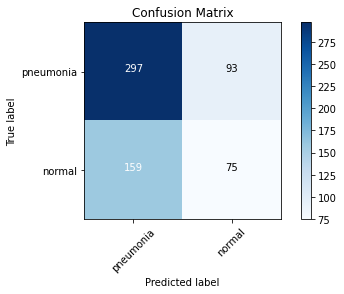

In [117]:
predictions = cnn_rmsprop.predict(x=validation_generator, steps = 1, verbose=0)
cm = confusion_matrix(y_true=validation_generator.classes, y_pred=np.argmax(predictions, axis=-1))

cm_plot_labels = ['pneumonia','normal']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [119]:
print(classification_report(validation_generator.classes, np.argmax(predictions, axis=-1)))

              precision    recall  f1-score   support

           0       0.65      0.76      0.70       390
           1       0.45      0.32      0.37       234

    accuracy                           0.60       624
   macro avg       0.55      0.54      0.54       624
weighted avg       0.57      0.60      0.58       624

